# Polyphase optimality test

The question that we want to answer is how suboptimal the polyphase filterbank is in getting the signal.
This is non-trivial to design and compare with FFT, since the trivial FFT and filterbanks have different underlying assumptions:

 * For FFT, we assume that the signal is periodic in the box. In that sense, only funamdental frequencies and their multiples are allowed. If you feed it a pure sinusoidal form that is not a multiple of the fundamental frequency, its power will alias into allowed frequencies. In that sense, if you are looking for an exact fundamental frequency, then pure FFT is bound to do better than polyphase filterbank.
 
 * In polyphase filterbank, we assume the power is coming in bandpowers that are flat between $f-\Delta f/2$ and $f+\Delta f/2$ (or whatever shape is assumed), rather than being delta functions at fundamental frequencies. A sine form outside the fundamental frequency will now "excite" only a single band-power but in that sense it is sub-optimal: to really excite an optimal band-pass we should shove in power over the entire band-width. Hence, this is also suboptimal for very sharply peaked frequency signals.
 
Here we are trying to test this using white noise. White noise has the same power everywhere and hence FFT should be equally good at picking it than polyphase filterbank (although they will interpret it differently).


In [1]:
import numpy as np
from numpy.fft import rfft,irfft
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def polyphase(sam,Na, Nx,dt):
    """ Polyphase filterbank implementation
    param sam : input sample the size of Na*Nx
    param Na : Number of Nx - sized chunks
    param Nx : Size of the final FFT
    param dt : delta t between two subsequent samples
    
    returns freq,pow: frequency array (size Nx) and power array size Nx
    """
    
    Nt=Na*Nx
    assert(len(sam)==Nt)
    rang=arange(Nt)
    filt=numpy.sinc((rang-Nt/2)/(1.0*Nx))
    filt*=0.5*(1-cos(rang*2*np.pi/Nt))
    filt*=sam
    for j in range(Na):
        if j==0:
            pp=filt[0:Nx]
        else:
            pp+=1*filt[j*Nx:(j+1)*Nx]
    pow=rfft(pp)
    pow=abs(pow*pow)
    tmax=Nx*dt
    freq=arange(len(pow))/tmax/1e6
    return freq,pow

In [3]:
def crappyphase(sam,Na,Nx,dt):
    """ Trivial FFT implementation with the same interface as polyphase
    param sam : input sample the size of Na*Nx
    param Na : Number of Nx - sized chunks
    param Nx : Size of the final FFT
    param dt : delta t between two subsequent samples
    
    returns freq,pow: frequency array (size Nx) and power array size Nx

    This performs the FFT Na times and averages the power over Nx chunks. No attempt at unaliasing.
    """

    Nt=Na*Nx
    assert(len(sam)==Nt)
    rang=arange(Nt)
    for j in range(Na):
        pow=rfft(sam[j*Nx:(j+1)*Nx])
        if j==0:
            tpow=abs(pow*pow)
        else:
            tpow+=abs(pow*pow)
    pow=tpow/Na
    tmax=Nx*dt
    freq=arange(len(pow))/tmax/1e6
    return freq,pow

### funamental vs non-fundamental frequency

In the first case, FFT should do better, in the second one polyphase

32
32


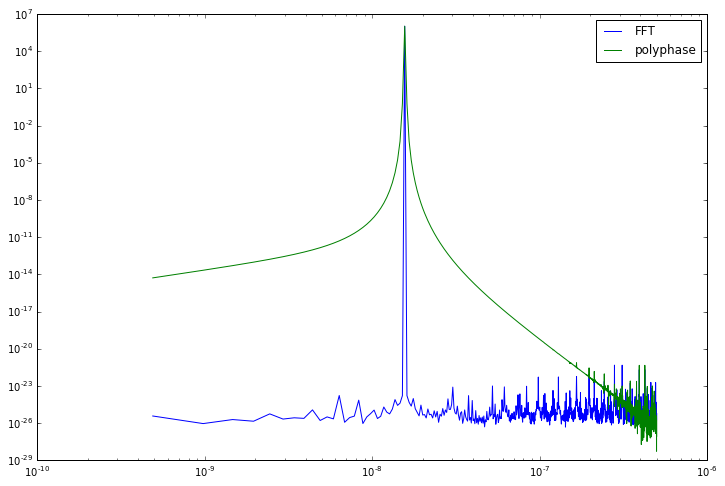

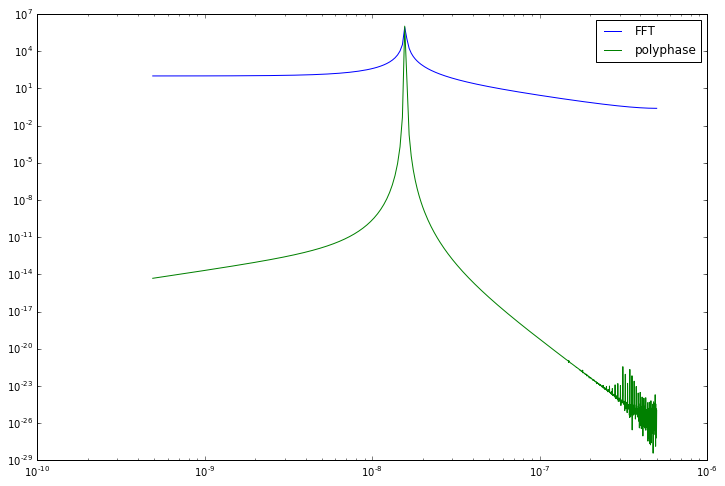

In [4]:
# let's try a multiple of fundamental freq
# and an offset. In the first case one straight FFT should do better,
# in the second one the polyphase

Nx=2048
Na=8
t=arange(Na*Nx)
for freq in [256.,258.]: #
    figure(figsize=(12,8))
    sam=sin(t*freq/Na/Nx*np.pi*2)
    #plot(t,sam)
    freq,res=crappyphase(sam,Na,Nx,1.)
    plot(freq,res, label="FFT")
    freq,res=polyphase(sam,Na,Nx,1.)
    plot(freq,res, label="polyphase")
    print res.argmax()
    legend()
    loglog()

## white noise test

In whatfollows, we will do test on white noise. We will take FFTs of the size Nx over the range of Na. We should measure white noise. The variance in the estimates should be a good estimate of errorbars.

In [5]:
Nx=2048*16
Nar=range(1,10)
snr=[]
snrp=[]
for Na in Nar:
    sam=np.random.normal(0,1.,Na*Nx)
    freq,res=crappyphase(sam,Na,Nx,1.)
    ## each time we feed it a longer sample, so we do expect snr to increase with
    ## sqrt (Na). We correct for that.
    snr.append(res[1:-1].mean()/sqrt(res.var())/sqrt(Na))   
    freq,res=polyphase(sam,Na,Nx,1.)
    snrp.append(res[1:-1].mean()/sqrt(res.var())/sqrt(Na))   


The plot below looks very strange, as if polyphase is just not adding any new information upone increasing Na.

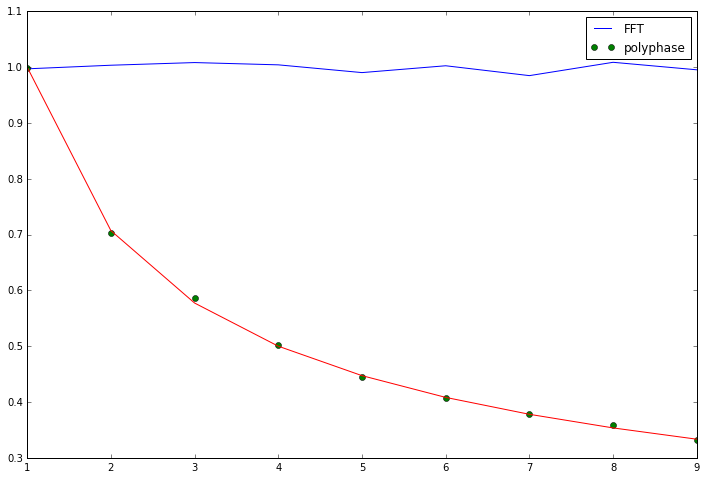

In [6]:
figure(figsize=(12,8))
plot(Nar,snr, label='FFT')
plot(Nar,snrp,'go',label='polyphase')
plot(Nar,1/sqrt(Nar),'r-')
legend()

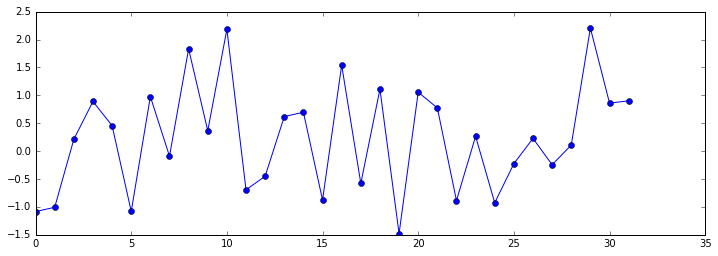

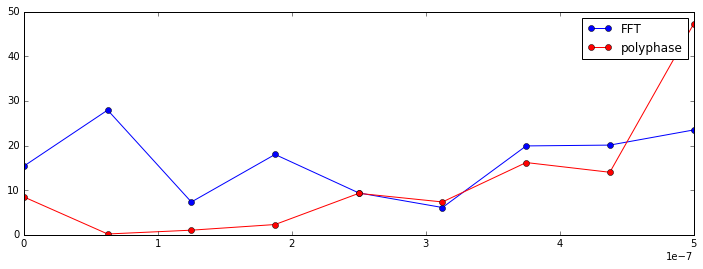

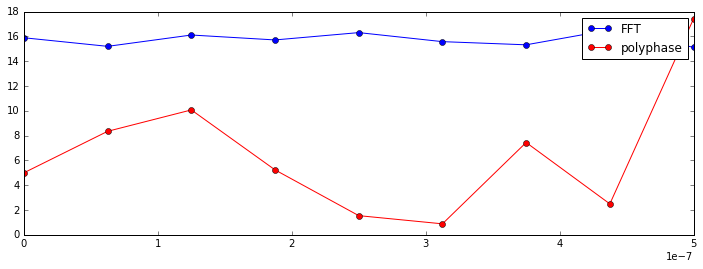

In [7]:
## Let's first see if things make sense at all.
Nx=16
Nar=[2,1024]
for Na in Nar:
    sam=np.random.normal(0,1.,Na*Nx)
    if (Na==2):
        figure(figsize=(12,4))
        plot(arange(len(sam)),sam,'bo-')
        
    freq,resc=crappyphase(sam,Na,Nx,1.)
    freq,resp=polyphase(sam,Na,Nx,1.)
    figure(figsize=(12,4))
    plot (freq,resc,'bo-',label='FFT')
    plot (freq,resp,'ro-',label='polyphase')
    legend()


In [8]:
def plot_filter(Na,Nx):
    Nt=Na*Nx
    rang=arange(Nt)
    filt=numpy.sinc((rang-Nt/2)/(1.0*Nx))
    filt*=0.5*(1-cos(rang*2*np.pi/Nt))
    plot(rang-Nt/2*0,filt)


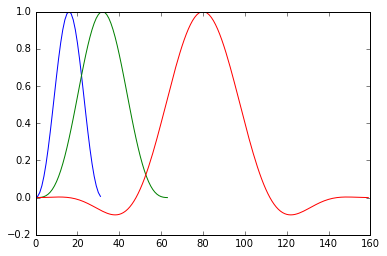

In [9]:
plot_filter(1,32)
plot_filter(2,32)
plot_filter(5,32)